# Semivariogram exploration

Rushing into Kriging is a bad idea. You can interpolate values automatically but never know if a process is spatially dependent. The kriging model will return something even when there is no spatial dependency, and it is a dangerous situation because the output might look correct, being wildly wrong.

The easiest way to deal with this problem is to check the variogram before modeling. Feel obligated to do this manual step because it could save you time and money! Variograms will tell you if there is a spatial relation between point pairs and how distance defines it.

In this exercise, we compute the experimental semivariogram, check it, and apply different theoretical models to find the best fit.

## Prerequisites

- **Domain**:
  - semivariance and covariance functions
- **Package**:
  - installation
- **Programming**:
  - Python basics

## Table of contents

1. Data preparation
2. Create the experimental variogram
3. Set manually different semivariogram models
4. Fit the theoretical model automatically
5. Export model
6. Import model

## Dataset

Dataset in this tutorial is the Digital Elevation Model around Gorzów Wielkopolski city in Poland.

In [10]:
import geopandas as gpd
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from pyinterpolate import reproject_flat, ExperimentalVariogram



## Chapter 1: data preparation

In [11]:
DEM_FILE = '../data/dem.csv'

In [12]:
df = pd.read_csv(DEM_FILE)
df.head()

,longitude,latitude,dem
0,15.115241,52.765146,91.275597
1,15.115241,52.742790,96.548294
2,15.115241,52.710706,51.254551
3,15.115241,52.708844,48.958282
4,15.115241,52.671378,16.817863


Data is stored in EPSG:4326 and has geographic coordinates, it must be reprojected to projected coordinate reference system. Polish area can be projected into EPSG:2180 (metric).

We cannot reproject points easily, first we need to transform `longitude` and `latitude` columns into shapely `Point()` objects, and set **CRS**, and in the next step we can transform those points into EPSG:2180. `Pyinterpolate` has function `reproject_flat()` which takes care of all those steps and returns the same object type as input to it (numpy array or pandas DataFrame).

In [13]:
r_df = reproject_flat(
    ds=df,
    in_crs=4326,
    out_crs=2180,
    lon_col='longitude',
    lat_col='latitude'
)

In [14]:
r_df.head()

,dem,longitude,latitude
0,91.275597,238012.301750,551466.805222
1,96.548294,237878.001294,548982.351111
2,51.254551,237685.325393,545416.708315
3,48.958282,237674.140301,545209.671315
4,16.817863,237449.254870,541045.934750


We might transform this `DataFrame` into `GeoDataFrame` - mostly for plotting purposes, to see what lies behind this dataset.

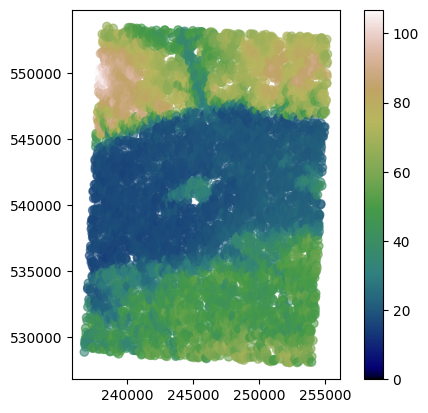

In [15]:
dem_geometry = gpd.points_from_xy(x=r_df['longitude'], y=r_df['latitude'], crs=2180)
dem = gpd.GeoDataFrame(df, geometry=dem_geometry)

dem.plot(column='dem', cmap='gist_earth', alpha=0.6, vmin=0, legend=True);

Data covers almost whole area, and this scenario is not realistic, so we will let only 1% of points in a dataset and then proceed to the variogram analysis and modeling.

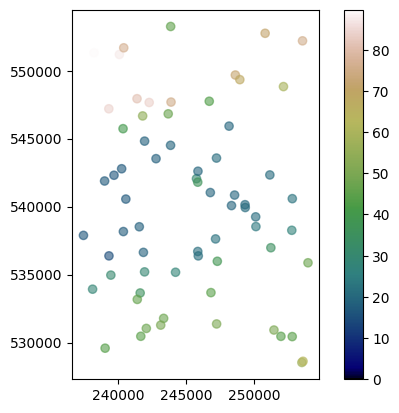

In [16]:
sample = dem.sample(int(0.01 * len(dem)))
sample.plot(column='dem', cmap='gist_earth', alpha=0.6, vmin=0, legend=True);

## Chapter 2: Experimental Variogram

To be sure that we can interpolate missing values with Kriging we must check if there is any relation between observation pairs, and how strong is this relation. We use variograms - plots of the dissimilarity between point pairs along the increasing distance. There are two "types" of variograms that we must be aware of:

- The experimental (semi)variogram: directly showing differences between point pairs at specific distances - lags. It could be very messy. We use it to visually check if there is a spatial correlation.
- Theoretical (semi)variogram: is a function applied to the experimental variogram. It cannot be any function, there are few of those in literature (and implemented in `pyinterpolate`). We can apply those mappings manually or automatically minimizing OLS error between experimental POINTS and theoretical FUNCTION.

We start our analysis by setting up the experimental model. We use class `ExperimentalVariogram` to set up the object (the class has an alias function `build_experimental_variogram()` but we won't use it). Class takes multiple parameters:

- `ds` : numpy array - ``[x, y, value]``
- `step_size` : float - The fixed distance between lags grouping point neighbors.
- `max_range` : float - The maximum distance at which the semivariance is calculated.
- `direction` : float, optional - Direction of semivariogram, values from 0 to 360 degrees.
- `tolerance` : float, optional - Controlling the cone within points are treated as neighbors in directional variogram.
- `dir_neighbors_selection_method` : str, default = 't' - Directional variogram neighbors selection method.
- `custom_bins` : numpy array, optional - Custom lags (new in Pyinterpolate 1.x).
- `custom_weights` : numpy array, optional - Custom weights assigned to points. Only semivariance values are weighted.
- `is_semivariance` : bool, default=True - Calculate experimental semivariance.
- `is_covariance` : bool, default=True - Calculate experimental coviariance.
- `as_cloud` : bool, default=False - Calculate semivariance point-pairs cloud.

We won't set `direction`, `tolerance`, `dir_neighbors_selection_method`, `custom_bins`, and `custom_weights` parameters. Other parameters are set as in the cell below.

In [17]:
step_size = 500  # meters - remember, that this parameter is related to projection!
max_range = 10_000  # meters - remember, that this parameter is related to projection!

is_semivariance = True
is_covariance = True
as_cloud = True  # we will get additional insights into our dataset!

ds = sample[['longitude', 'latitude', 'dem']].to_numpy()

In [18]:
experimental_variogram = ExperimentalVariogram(
    ds=ds,
    step_size=step_size,
    max_range=max_range,
    is_semivariance=is_semivariance,
    is_covariance=is_covariance,
    as_cloud=as_cloud
) 

Exception in thread Thread-45 (_get):
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/threading.py", line 1052, in _bootstrap_inner
Exception in thread Thread-46 (_get):
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/threading.py", line 1052, in _bootstrap_inner
Exception in thread Thread-47 (_get):
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/threading.py", line 1052, in _bootstrap_inner
Exception in thread Thread-49 (_get):
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/threading.py", line 1052, in _bootstrap_inner
Exception in thread Thread-48 (_get):
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/threading.py", line 1052, in _bootstrap_inner
Exception in thread Thread-50 (_get